# Imports & Others

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Reproducibility
torch.manual_seed(31)
torch.cuda.manual_seed(31)

In [3]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Setting the hyperparameters up
NUM_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.003
N_TEST_IMG = 5

# What are Autoencoders?

Autoencoders are a type of artificial neural network used for unsupervised learning. They're particularly useful for tasks like dimensionality reduction, feature learning, and data denoising. The basic idea behind autoencoders is to encode input data into a lower-dimensional representation and then decode it back to its original form, attempting to minimize the reconstruction error.

Here's a breakdown of the components and workings of autoencoders:

1. Encoder:

    The encoder takes the input data and compresses it into a latent-space representation. This latent representation typically has a lower dimensionality than the input data, capturing its most important features. The encoder network consists of one or more layers of neurons that transform the input data into a compact representation.

2. Decoder:

    The decoder network takes the compressed representation produced by the encoder and attempts to reconstruct the original input data. It mirrors the structure of the encoder but in reverse, expanding the latent representation back to the original dimensionality. The goal of the decoder is to produce an output that closely matches the input data.

3. Latent Space
    
    The latent space is the reduced-dimensional representation of the input data learned by the autoencoder. It captures the essential features of the input, allowing the network to reconstruct it with minimal loss of information. The size of the latent space is a hyperparameter chosen by the designer and influences the level of compression applied to the input data.


Now let's move onto regularization

Types:
1. Weight decay:

    Also known as L2 regularization, it is a commonly used technique in machine learning to prevent overfitting by penalizing large weights in the model. In the context of autoencoders, weight decay involves adding a regularization term to the loss function that penalizes the squared magnitudes of the weights in the encoder and decoder networks. This encourages the network to learn simpler and smoother representations of the input data by shrinking the weights towards zero, effectively reducing the model's capacity and preventing it from fitting noise in the training data.

1. Sparse Autoencoders:

    Sparse autoencoders introduce sparsity constraints on the activations of the hidden layers during training. By penalizing non-zero activations, sparse autoencoders encourage the model to learn sparse representations of the input data, where only a small subset of neurons are active at a given time. This regularization technique helps in feature learning and dimensionality reduction tasks by promoting the discovery of the most informative features while discarding irrelevant ones.

2. Denoising Autoencoders:

    Denoising autoencoders are trained to remove noise from input data by learning to reconstruct clean data from corrupted versions. During training, the autoencoder is fed with noisy input data, and it learns to minimize the reconstruction error between the clean data and the output of the decoder. Denoising autoencoders implicitly incorporate regularization by forcing the model to learn robust representations that are resilient to noise, making them suitable for tasks like image denoising, speech enhancement, and signal processing.

3. Contractive Autoencoders:

    Contrastive autoencoders are a type of autoencoder that leverage contrastive learning techniques for representation learning. Contrastive learning aims to learn representations by contrasting positive pairs (similar samples) with negative pairs (dissimilar samples). In the context of autoencoders, contrastive learning is used to encourage the encoder to produce similar latent representations for similar input samples and dissimilar representations for dissimilar samples.



# Data Preparation

### Data Collection

In [5]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root = '../input/mnist/mnist/',
    train = True,                                     # this is training data
    transform = torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download = True,                        # download it if you don't have it
)

test_data = torchvision.datasets.MNIST(
    root = '../input/mnist/mnist/',
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 107337586.09it/s]


Extracting ../input/mnist/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../input/mnist/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4093390.12it/s]


Extracting ../input/mnist/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/mnist/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29964088.44it/s]


Extracting ../input/mnist/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/mnist/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12933149.20it/s]

Extracting ../input/mnist/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/mnist/mnist/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


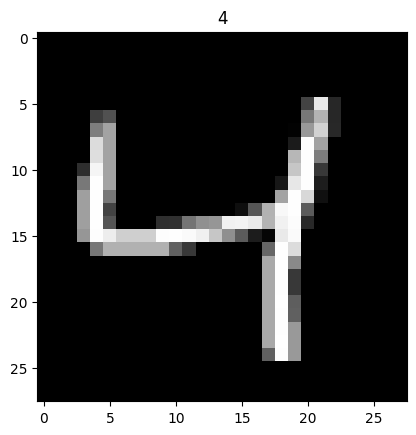

In [6]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)


plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

## Dataloaders

In [7]:
train_loader = Data.DataLoader(dataset = train_data,
                               batch_size = BATCH_SIZE,
                               shuffle = True)

test_loader = Data.DataLoader(dataset = test_data,
                               batch_size = BATCH_SIZE,
                               shuffle = False)

# Autoencoder Model

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
model = AutoEncoder().to(device)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [10]:
# Loss Function & Optimizer

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LEARNING_RATE)

# Training the Vanilla Model

Epoch:  0 | train loss: 0.2333


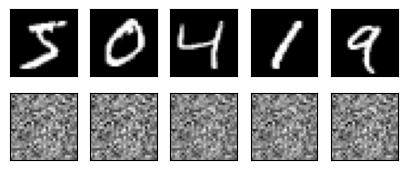

Epoch:  0 | train loss: 0.0616


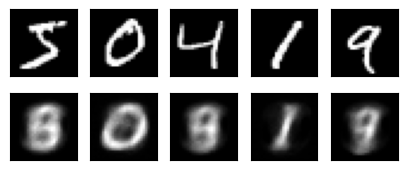

Epoch:  5 | train loss: 0.0353


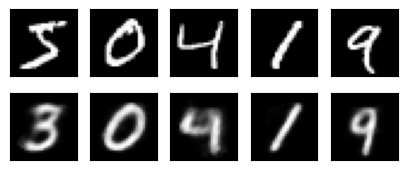

Epoch:  5 | train loss: 0.0338


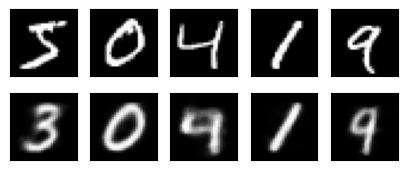

Epoch:  14 | train loss: 0.0352


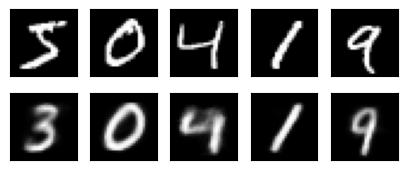

Epoch:  14 | train loss: 0.0372


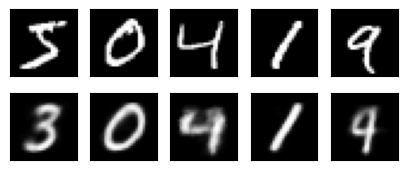

In [11]:
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)

for epoch in range(NUM_EPOCHS):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
        b_label = Variable(y).to(device)               # batch label

        encoded, decoded = model(b_x)

        loss = loss_fn(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, NUM_EPOCHS-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())

            # plotting decoded image (second row)
            _, decoded_data = model(view_data)
            decoded_data = decoded_data.cpu().detach().numpy()  # Move data to CPU for visualization

            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))

            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(())
                a[0][i].set_yticks(())

            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(())
                a[1][i].set_yticks(())

            plt.show()
            plt.pause(0.05)


# Implementation of the Types of Regularization

## L2 or Weight Decay

```
        ...

        # Calculate  loss
        loss = loss_fn(decoded, b_y)

        # L2 regularization term
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param)**2

        # Add L2 regularization to the loss
        loss += lambda_l2 * l2_reg

        optimizer.zero_grad()               
        loss.backward()       
        optimizer.step()

        ...
```


## Sparse Autoencoder

```
# Define sparsity target and penalty coefficient
sparsity_parameter = 0.1
lambda_sparse = 0.01

    ...

    # Calculate reconstruction loss
    loss = loss_fn(decoded, b_y)

    # Calculate sparsity loss (KL divergence)
    avg_activation = torch.mean(F.sigmoid(encoded), dim=0)  # Average activation for each neuron

    kl_divergence = torch.sum(sparsity_parameter * torch.log(sparsity_parameter / avg_activation) + (1 - sparsity_parameter) * torch.log((1 - sparsity_parameter) / (1 - avg_activation)))
        
    # Add sparsity penalty to the loss
    loss += lambda_sparse * kl_divergence

    
    optimizer.zero_grad()               # clear gradients for this training step
    loss.backward()                     # backpropagation, compute gradients
    optimizer.step()

    ...    

```

## Denoising Autoencoder

```
# Define the probability of setting a pixel to zero (noise level)
noise_level = 0.2

for epoch in range(NUM_EPOCHS):
    for step, (x, y) in enumerate(train_loader):
        # Add noise to the input data
        noise = torch.randn(x.size()) * noise_level
        noisy_x = x + noise

        ...
```

## Contractive Autoencoder

```
# Define the regularization coefficient
lambda_contractive = 0.1

def compute_jacobian(inputs, outputs):
    """
    Compute the Jacobian of the network with respect to the inputs.
    """
    num_inputs = inputs.size(0)
    num_outputs = outputs.size(1)
    jacobian = torch.zeros(num_outputs, num_inputs)
    for i in range(num_inputs):
        inputs.requires_grad = True
        outputs_i = outputs[:, i]
        grad_outputs_i = torch.zeros_like(outputs)
        grad_outputs_i[:, i] = 1
        outputs_i.backward(grad_outputs_i, retain_graph=True)
        jacobian[:, i] = inputs.grad.view(-1)
        inputs.grad.zero_()
    return jacobian

...
        ...

        # Calculate reconstruction loss
        loss = loss_fn(decoded, b_y)

        # Compute the Jacobian of the network with respect to the inputs
        jacobian = compute_jacobian(b_x, encoded)

        # Calculate the Frobenius norm of the Jacobian matrix
        frob_norm = torch.norm(jacobian, p='fro')

        # Add contractive regularization to the loss
        loss += lambda_contractive * frob_norm

        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()

        ...
```